# Estimating the effect of bright spots on the broad-band spectrum of TRAPPIST-1 planets

From [Rackham et al. 2018](http://adsabs.harvard.edu/abs/2018ApJ...853..122R), the observed transit depth as a function of wavelength $D_{\lambda, obs}$is modulated by stellar heterogeneity: 

$$ D _ { \lambda ,o b s } = \frac { D _ { \lambda } } { 1- f _ { h e t } \left( 1- \frac { F _ { \lambda ,h e t } } { F _ { \lambda ,p h o t } } \right) }$$

Dividing by $D_\lambda$, we define $\epsilon$, 

$$ \epsilon _ { \lambda ,s } = \frac { 1} { 1- f _ { s p o t } \left( 1- \frac { F _ { \lambda ,s p o t } } { F _ { \lambda } ,p h o t } \right)}, $$ 

which Rackham et al describe as: 

> the **contamination spectrum** produced by the combination of unocculted spots

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

Transit depths from Elsa Ducrot: 

In [73]:
wl = np.array([650, 903, 3600, 4500])/1000
b_depth = np.array([0.716, 0.752, 0.7265, 0.7223])
b_depth_err = np.array([0.030, 0.027, 0.0079, 0.0081])

c_depth = np.array([0.693, 0.738, 0.729, 0.7019])
c_depth_err = np.array([0.021, 0.027, 0.015, 0.0081])

Import BT-Settle PHOENIX model atmospheres: 

In [9]:
from glob import glob

paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

from astropy.io import fits

wavelengths = fits.getdata(paths[0])['Wavelength']

temperatures = []
model_fluxes = []

for path in paths:
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

Effective temperature for TRAPPIST-1 from [Delrez et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.475.3577D):

In [82]:
teff = 2511
trappist1_flux = model_fluxes[np.argmin(np.abs(temperatures-teff)), :] * wavelengths

Calculate $\epsilon_{\lambda, s}$ for a variety of spot temperatures $T_\mathrm{spot} \in \{3000, 3500, 4000, 4500, 5000\}$:

In [97]:
from scipy.ndimage import gaussian_filter1d
typical_spot_radius = 0.00599

epsilons = []
spot_temperatures = [3000, 3500, 4000, 4500, 5000]
for spot_temperature in spot_temperatures:
    hotspot_flux = model_fluxes[np.argmin(np.abs(temperatures-spot_temperature)), :] * wavelengths
    c = gaussian_filter1d(hotspot_flux/trappist1_flux, 1000)
    eps = 1 / (1 - typical_spot_radius**2 * (1 - c))
    epsilons.append(eps)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Get filter transmittance profiles for the relevant filters: 

In [108]:
kepler_wavelength, kepler_trans = np.loadtxt('../libra/data/filters/kepler_response_hires1.txt', unpack=True)
kepler_wavelength /= 1000

I_wavelength, I_trans = np.loadtxt('../libra/data/filters/Generic_Cousins.I.dat.txt', unpack=True)
I_wavelength /= 10000

z_wavelength, z_trans = np.loadtxt('../libra/data/filters/SLOAN_SDSS.z.dat.txt', unpack=True)
z_wavelength /= 10000

s1_wavelength, s1_trans = np.loadtxt('../libra/data/filters/Spitzer_IRAC.I1.txt', unpack=True)
s1_wavelength /= 10000

s2_wavelength, s2_trans = np.loadtxt('../libra/data/filters/Spitzer_IRAC.I2.txt', unpack=True)
s2_wavelength /= 10000

iz_wavelength = np.sort(np.concatenate([I_wavelength, z_wavelength]))
iz_trans = np.interp(iz_wavelength, I_wavelength, I_trans) + np.interp(iz_wavelength, z_wavelength, z_trans)

band_widths = np.array([kepler_wavelength.ptp(), iz_wavelength.ptp(), s1_wavelength.ptp(), s2_wavelength.ptp()])/3

Compute the mean $\epsilon_{\lambda, s}$ for the $j$th filter with transmittance $T_{\lambda, j}$: 

$$\bar{\epsilon}_{j} = \frac{\int T_{\lambda, j} \epsilon_{\lambda, s} d\lambda}{\int T_{\lambda, j}d\lambda}$$

In [86]:
def transmittance_weighted_eps(filter_wavelength, filter_transmittance, wavelength, epsilon):
    """
    See description in note above!
    """
    normed_trans = filter_transmittance
    epsilon_interp = np.interp(filter_wavelength, wavelength, epsilon)
    transmittance_weighted_epsilon = (np.trapz(filter_transmittance * epsilon_interp, filter_wavelength) / 
                                      np.trapz(filter_transmittance, filter_wavelength))
    return transmittance_weighted_epsilon

In [110]:
# plt.plot(wavelengths, eps, lw=3, color='k')

# plt.plot(kepler_wavelength, kepler_trans, label='Kepler')
# plt.plot(iz_wavelength, iz_trans, label='I+z')
# plt.plot(s1_wavelength, s1_trans, label='I1')
# plt.plot(s2_wavelength, s2_trans, label='I2')

# plt.scatter(wl, epsilon_obs, marker='s', s=50, label='$\epsilon$')

# plt.xlim([0.4, 5.5])
# plt.legend()

In [89]:
def linear_model(X, y, err):
    """
    Least squares linear regression
    """
    omega = np.diag(err**2)
    omega_inv = np.linalg.inv(omega)

    V = np.linalg.inv(X.T @ omega_inv @ X)
    beta = V @ X.T @ omega_inv @ y
    betas = beta[0]
    betas_errs = np.sqrt(np.diag(V))[0]
    return betas

Regress the set of transmittance-weighted $\{\epsilon_j\}$ against the observed depths $D_{j, obs}$

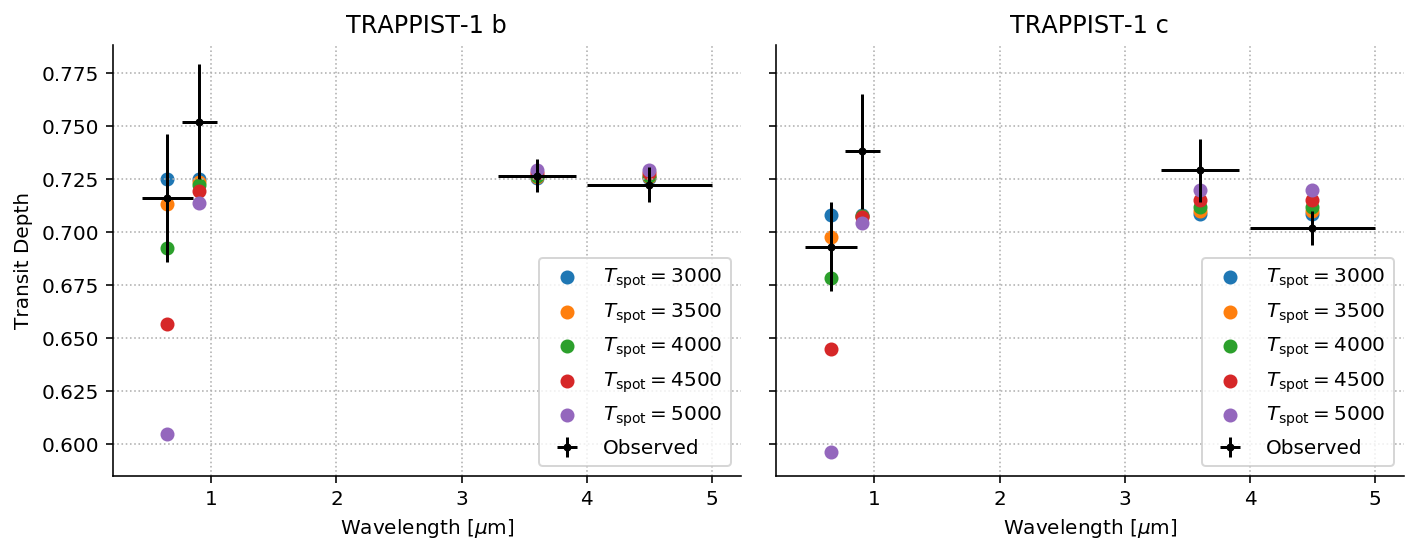

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax[0].errorbar(wl, b_depth, yerr=b_depth_err, xerr=band_widths, fmt='.', color='k', label='Observed')
ax[0].set_title('TRAPPIST-1 b')

ax[1].errorbar(wl, c_depth, yerr=c_depth_err, xerr=band_widths, fmt='.', color='k', label='Observed')
ax[1].set_title('TRAPPIST-1 c')

for eps, temp in zip(epsilons, spot_temperatures):
    eps_spitzer1 = transmittance_weighted_eps(s1_wavelength, s1_trans, wavelengths, eps)
    eps_spitzer2 = transmittance_weighted_eps(s2_wavelength, s2_trans, wavelengths, eps)

    eps_kepler = transmittance_weighted_eps(kepler_wavelength, kepler_trans, wavelengths, eps)
    eps_spec = transmittance_weighted_eps(iz_wavelength, iz_trans, wavelengths, eps)

    epsilon_obs = np.array([eps_kepler, eps_spec, eps_spitzer1, eps_spitzer2])

    b_coeff = linear_model(epsilon_obs[:, np.newaxis], b_depth, b_depth_err)
    c_coeff = linear_model(epsilon_obs[:, np.newaxis], c_depth, c_depth_err)
    ax[1].scatter(wl, c_coeff * epsilon_obs, label="$T_\mathrm{{spot}} = {0}$".format(temp))
    ax[0].scatter(wl, b_coeff * epsilon_obs, label="$T_\mathrm{{spot}} = {0}$".format(temp))

for axis in ax:
    axis.set_xlabel('Wavelength [$\mu$m]')
    axis.legend()
    for j in ['top', 'right']:
        axis.spines[j].set_visible(False)
    axis.grid(ls=':')
ax[0].set_ylabel('Transit Depth')
fig.tight_layout()
fig.savefig('transit_depth_constraints.pdf', bbox_inches='tight')